# Feature Engineering
[Video](https://mstream.hm.edu/paella/ui/watch.html?id=4b798801-4f2e-4407-972f-05c82865d119)

**Bisher:** Saubere Features-Matrix; insbesondere waren die Features stets *numerisch*

Weitere wichtige Arten von Daten, die man als Features verwenden möchte sind u.a.:
- Kategorien
- Text
- (Bilder)
- Abgeleitete, konstruierte, synthetische Daten

## Kategorische Daten
Beispiel Immobilienpreise: Hier sind neben numerischen Features (z.B. Anzahl der Zimmer, Grundfläche) auch Features relevant, die in Kategorien vorliegen, z.B. der Stadtteil.

Beispieldaten:

In [1]:
data = [
    {'preis': 1850000, 'zimmer': 4, 'stadtteil': 'Neuhausen'},
    {'preis': 900000, 'zimmer': 3, 'stadtteil': 'Schwabing'},
    {'preis': 650000, 'zimmer': 3, 'stadtteil': 'Freimann'},
    {'preis': 400000, 'zimmer': 2, 'stadtteil': 'Laim'},
    {'preis': 400000, 'zimmer': 1, 'stadtteil': 'Schwabing'},
]

Naheliegende Option: Ordne jedem Stadtteil eine Zahl zu:
- Neuhausen: 1
- Schwabing: 2
- Freimann: 3
- Laim: 4

Das ist nicht sonderlich sinnvoll, da numerischen Werten immer unterstellt wird, dass sie algebraische Eigenschaften widerspiegeln, also z.B. Neuhausen + Schwabing = Freimann oder Schwabing < Laim. Da dies keinen Sinn macht, darf es im Modell nicht so verwendet werden.

Mögliche Lösung *One-Hot-Encoding*:
- Erstellt für *jeden möglichen Wert* ein eigenes Feature (also z.B. ein Feature "Stadteil_ist_Schwabing")
- Dieses Feature hat dann entweder den Wert 1 oder 0 (je nachdem, ob im Beispiel der Stadtteil Schwabing ist oder nicht)

In ``sklearn`` gibt es diverse Möglichkeiten, dieses One-Hot-Encoding durchzuführen. In unserem Fall liegen die Daten in Form eines sog. Dictionary vor, d.h. in der Form

``[{'keyword1': wert, 'keyword2': wert, ...}, {das gleiche nochmal},...,{das gleiche noch ein letztes mal}]``.

Somit können wir den ``DictVecotrizer`` verwenden. Weitere Möglichkeiten sind ``sklearn.preprocessing.OneHotEncoder`` und ``sklearn.feature_extraction.FeatureHasher``.


In [2]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

c:\Users\Cris\anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


array([[1850000,       0,       0,       1,       0,       4],
       [ 900000,       0,       0,       0,       1,       3],
       [ 650000,       1,       0,       0,       0,       3],
       [ 400000,       0,       1,       0,       0,       2],
       [ 400000,       0,       0,       0,       1,       1]])

Es gibt nun keinen Eintrag mehr für den Stadtteil, denn dieser wurde aufgeteilt in vier One-Hot-Spalten (für jeden vorkommenden Stadtteil eine). Damit haben wir wieder eine Features-Matrix, die nur numerische Werte enthält.

Die Namen der Spalten sind folgendermaßen verfügbar:

In [11]:
vec.get_feature_names_out()

array(['adjektiv', 'ein', 'hilfreich', 'ist', 'lernen', 'macht',
       'maschinelles', 'spass', 'und', 'wichtig'], dtype=object)

Nachteil: Wenn die Kategorie viele verschiedene mögliche Werte hat, werden die Daten extrem aufgebläht -- und fast alles davon sind Nuller. Um einen effizienten Umgang damit zu ermöglichen, kann (und sollte) die Option ``sparse`` gewählt werden:

In [4]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<5x6 sparse matrix of type '<class 'numpy.int32'>'
	with 15 stored elements in Compressed Sparse Row format>

## Text
Um ein Modell zu erstellen, das mit Texten umgehen kann, ist es notwendig, aus dem Text relevante numerische Werte zu extrahieren.

Einfach(st)e Möglichkeit: Wörter zählen:

In [5]:
sample = ['maschinelles lernen ist hilfreich',
          'hilfreich ist ein adjektiv',
          'lernen macht spass und ist wichtig']

In diesem Sample gibt es zehn verschiedene Wörter. Es soll eine Tabelle erstellt werden, die für jedes Satzfragment angibt, wie oft jedes dieser acht Wörter auftritt. Dafür kann die Methode ``CountVectorizer`` verwendet werden:

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x10 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

Auch hier wird also eine Sparse Matrix verwendet (scheint sinnvoll, denn bei Text werden sehr viele Nuller entstehen).

Um das Ergebnis zu betrachten, wandeln wir es in einen ``DataFrame`` um:

In [8]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

,adjektiv,ein,hilfreich,ist,lernen,macht,maschinelles,spass,und,wichtig
0,0,0,1,1,1,0,1,0,0,0
1,1,1,1,1,0,0,0,0,0,0
2,0,0,0,1,1,1,0,1,1,1


**Problem:** Wörter die häufig auftreten bekommen damit ein (zu?) hohes Gewicht, was zu Problemen für die Klassifizierungs-Algorithmen führt.

**Mögliche Lösung:** TF-IDF (Term frequency-inverse document frequency) ist eine weit verbreitete Methode, die die Wörter mit einem Gewicht versieht, welches von ihrer Häufigkeit in den Texten abhängt.

Realisierung:

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

,adjektiv,ein,hilfreich,ist,lernen,macht,maschinelles,spass,und,wichtig
0,0.000000,0.000000,0.480458,0.373119,0.480458,0.000000,0.631745,0.000000,0.000000,0.000000
1,0.584483,0.584483,0.444514,0.345205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.266075,0.342620,0.450504,0.000000,0.450504,0.450504,0.450504


Eine genauere Beschreibung der TF-IDF Gewichtung, inkl. manuell durchgerechnetem Beispiel, ist [hier](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting) zu finden.

## Abgeleitete Features
Manchmal weiß man oder hat die Vermutung, dass neben einem Feature $f_1$ auch eine weitere Größe relevant sein könnte, die sich aus diesem ergibt, z.B. $\sin(f_1)$ oder $f_1^2$ etc.

Beispiel:

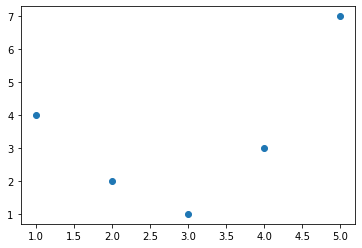

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

Als Feature haben wir nur ``x`` zu Verfügung. Lineare Regression kann also nur Geraden liefern:

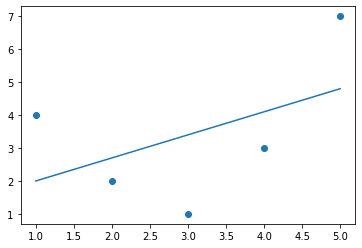

In [13]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

Nun können wir entweder ein komplexeres Modell verwenden (Vorschläge??) oder wir "reichern die Daten an", indem wir "synthetische" Features erzeugen, z.B. $x^2$ und $x^3$.

Solche polynomiellen Features können einfach erzeugt werden:

In [14]:
X

array([[1],
       [2],
       [3],
       [4],
       [5]])

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


Das sind unsere neuen, angereicherten Daten, die neben $x$ auch $x^2$ und $x^3$ enthalten.

Wir trainieren das gleiche Modell wie oben auf diesen Daten:

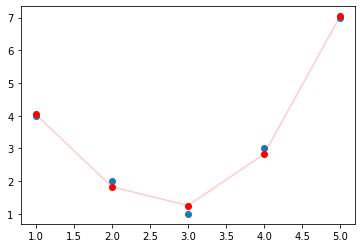

In [16]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.scatter(x, yfit, c='red');
plt.plot(x, yfit, c='red', alpha=0.2);

Das ergibt ein deutlich besseres Modell. Dieses haben wir erhalten, indem wir die **Input-Daten transformiert** haben, die Modellklasse ist die gleiche.

**Wichtig:** Dieses Modell erwartet nun immer die transformierten/angereicherten/vierdimensionalen Inputdaten. Konkret gelernt hat das Modell die Parameter ``model.intercept_`` und ``model.coef_``. Letztere beziehen sich stets auf die transformierten Inputdaten $x,\ x^2,\ x^3$.

In [17]:
print("model.intercept_ = ", model.intercept_)
print("model.coef_ = ", model.coef_)

model.intercept_ =  7.399999999999771
model.coef_ =  [-3.76190476  0.32142857  0.08333333]


Um dies zu verdeutlichen, plotten wir die Vorhersagen des Modells "von Hand" (wir verwenden also nicht wie sonst üblich die Methode ``model.predict()``):

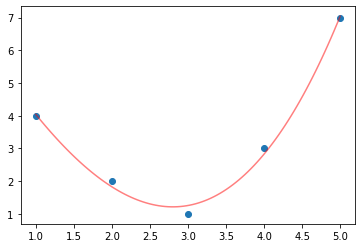

In [18]:
x_plot = np.linspace(1.0, 5.0, 100)
plt.scatter(x, y)
plt.plot(x_plot, model.intercept_ + model.coef_[0]*x_plot + model.coef_[1]*x_plot**2 + model.coef_[2]*x_plot**3, c='red', alpha = 0.5)

## Umgang mit fehlenden Daten
Viele Datensätze aus der realen Anwendung sind unvollständig. Lücken sind meist mit ``NaN`` (not a number) belegt.
Bevor ein Modell damit trainiert werden kann, müssen diese Lücken beseitigt werden.

Beispiel:

In [19]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

Das Füllen solcher Lücken wird *Imputation* genannt, eine Methode, die das macht, heißt *Imputer*. *Wie* die Lücken gefüllt werden sollen, ist sehr unterschiedlich (verwende Mittelwert der Spalte, verwende kompliziertes Verfahren, um den Wert wiederherzustellen).

In [20]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

## Feature Pipelines
Alles bisher beschriebene hat zum Ziel, die Inputdaten aufzubereiten, bevor sie dem Modell zum Trainieren übergeben werden. Das sollte idealerweise in einem einzigen einmal definierten Schritt automatisch passieren. Dafür gibt es in ``sklearn`` sog. ``Pipeline`` Objekte.

Beispiel: Wir wollen


1.   Fehlende Daten durch den Mittelwert der Spalte ersetzen
2.   Quadratische Features hinzufügen
3.   Eine lineare Regression anwenden



In [21]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(SimpleImputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

Dieses Objekt verhält sich wie ein normaler Estimator, d.h. wir können alle Schritte wie gewohnt durchführen:

In [22]:
model.fit(X, y)  # X von oben (MIT fehlenden Daten)
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]
